# Imports

In [1]:
import sys
sys.path.append('../statistics_related/')

from src.utils import *
from src.dgp import dgp_marketplace

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = dgp_marketplace().generate_data(N=10_000)
df

,age,sales,online,products
0,0.312777,450.858091,0,2
1,1.176221,1121.882449,1,3
2,1.764048,2698.714549,0,1
3,1.082742,1627.746386,0,3
4,3.156503,1464.593939,0,2
...,...,...,...,...
9995,0.619932,727.150749,1,2
9996,0.644573,4349.313355,0,2
9997,1.298081,213.913387,0,3
9998,1.054783,5380.731493,0,1


We have information on 10.000 firms. For each firm we know:

- `age`: the age of the firm
- `sales`: the monthly sales from last month
- `online`: whether the firm is only active online
- `products`: the number of products that the firm offers

# 1. Scatter Plot

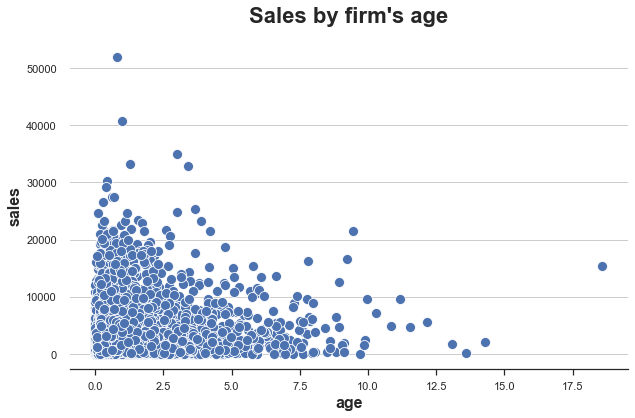

In [3]:
sns.scatterplot(x='age', y='sales', data=df);
plt.title("Sales by firm's age");

# 2. Hexplot

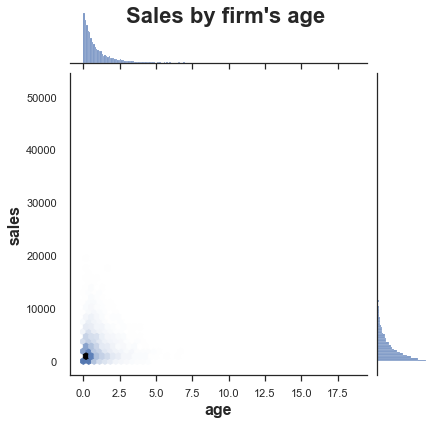

In [4]:
s = sns.jointplot(x='age', y='sales', data=df, kind='hex');
s.ax_joint.grid(False);
s.ax_marg_y.grid(False);
s.fig.suptitle("Sales by firm's age");

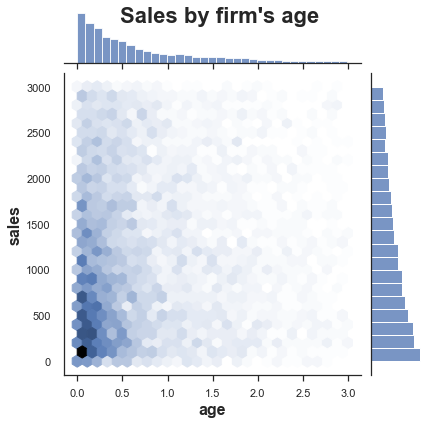

In [5]:
# Remove outliers and zoom-in
s = sns.jointplot(x='age', y='sales', data=df.query("age < 3 & sales < 3000"), kind="hex");
s.ax_joint.grid(False);
s.ax_marg_y.grid(False);
s.fig.suptitle("Sales by firm's age");

In [6]:
# apply natural log
df['log_age'] = np.log(df['age'])
df['log_sales'] = np.log(df['sales'])

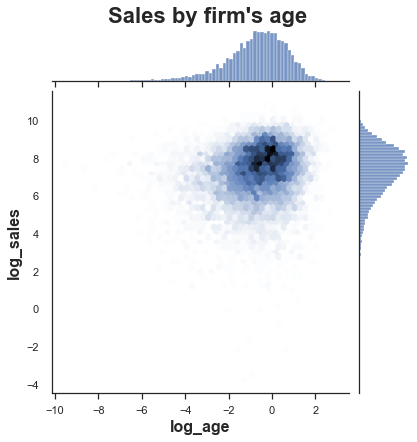

In [7]:
s = sns.jointplot(x='log_age', y='log_sales', data=df, kind='hex');
s.ax_joint.grid(False);
s.ax_marg_y.grid(False);
s.fig.suptitle("Sales by firm's age", y=1.02);

# Linear Regression (`log_sales` on `log_age`)

In [8]:
import statsmodels.formula.api as smf

In [9]:
smf.ols('log_sales ~ log_age', df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_sales   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     285.2
Date:                Tue, 25 Oct 2022   Prob (F-statistic):           4.09e-63
Time:                        21:04:26   Log-Likelihood:                -17347.
No. Observations:               10000   AIC:                         3.470e+04
Df Residuals:                    9998   BIC:                         3.471e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.3971      0.015    478.948      0.000       7.367       7.427
log_age        0.1690      0.010     16.888      0.000       0.149       0.189
==============================================================================
Omnibus:                     2011.851   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5178.954
Skew:                          -1.097   Prob(JB):                         0.00
Kurtosis:                       5.760   Cond. No.                         1.96
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
smf.ols('log_sales ~ log_age', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.3971,0.015,478.948,0.000,7.367,7.427
log_age,0.1690,0.010,16.888,0.000,0.149,0.189


With linear regression, we can condition the analysis on covariates. Let’s add the binary indicator for `online`-only firms and the variable counting the number of `products` to the regression.

In [11]:
smf.ols('log_sales ~ log_age + online + products', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.5717,0.037,176.893,0.000,6.499,6.644
log_age,0.0807,0.010,7.782,0.000,0.060,0.101
online,0.1447,0.027,5.433,0.000,0.092,0.197
products,0.3456,0.014,24.110,0.000,0.317,0.374


# 3. Binned Scatter Plot

The binned scatterplot is a very powerful tool that provides a flexible and parsimonious way of visualizing and summarizing conditional means (and not only) in large datasets.

The idea behind the binned scatterplot is to divide the conditioning variable, `age` in our example, into equally sized bins or quantiles, and then plot the conditional mean of the dependent variable, `sales` in our example, within each bin.

In [12]:
import binsreg

def binscatter(**kwargs):
    # Estimate binsreg
    est = binsreg.binsreg(**kwargs)
    
    # Retrieve estimates
    df_est = pd.concat([d.dots for d in est.data_plot])
    df_est = df_est.rename(columns={'x': kwargs.get("x"), 'fit': kwargs.get("y")})
    
    # Add confidence intervals
    if "ci" in kwargs:
        df_est = pd.merge(df_est, pd.concat([d.ci for d in est.data_plot]))
        df_est = df_est.drop(columns=['x'])
        df_est['ci'] = df_est['ci_r'] - df_est['ci_l']
    
    # Rename groups
    if "by" in kwargs:
        df_est['group'] = df_est['group'].astype(df[kwargs.get("by")].dtype)
        df_est = df_est.rename(columns={'group': kwargs.get("by")})

    return df_est

In [13]:
# Estimate binsreg
df_est = binscatter(x='age', y='sales', data=df, ci=(3,3))
df_est

,group,age,bin,isknot,mid,sales,ci_l,ci_r,ci
0,Full Sample,0.012556,0,0,0,1624.779616,1312.439124,1905.535412,593.096288
1,Full Sample,0.037015,1,0,0,1664.078013,1435.438411,1893.888819,458.450408
2,Full Sample,0.065813,2,0,0,1779.657894,1555.909281,1968.681960,412.772679
3,Full Sample,0.094486,3,0,0,1976.464837,1740.530049,2216.800005,476.269956
4,Full Sample,0.125363,4,0,0,2015.833752,1796.489393,2280.237320,483.747927
5,Full Sample,0.157361,5,0,0,2139.850346,1800.523351,2332.601628,532.078277
6,Full Sample,0.189610,6,0,0,2275.508877,2064.695162,2592.497382,527.802220
7,Full Sample,0.224357,7,0,0,2436.723697,2093.990694,2654.780453,560.789759
8,Full Sample,0.257130,8,0,0,2559.184044,2260.673893,2848.048823,587.374930
9,Full Sample,0.297189,9,0,0,2700.235997,2503.196835,3142.845555,639.648720


The `binscatter` function outputs a dataset in which, for each bin of the conditioning variable, `age`, we have values and confidence intervals for the outcome variable, `sales`.

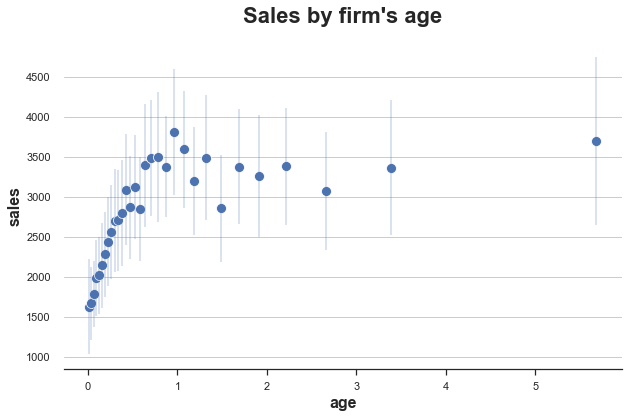

In [14]:
# Plot binned scatterplot
sns.scatterplot(x='age', y='sales', data=df_est);
plt.errorbar('age', 'sales', yerr='ci', data=df_est, ls='', lw=2, alpha=0.2);
plt.title("Sales by firm's age");

`binsreg` allows to condition the analysis on any number of variables, with the `w` option.

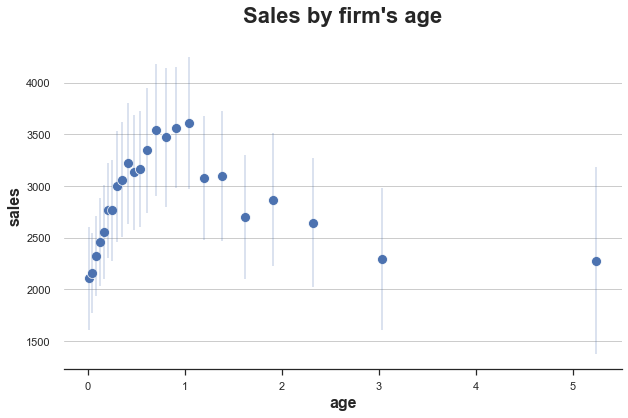

In [15]:
# Estimate binsreg
df_est = binscatter(x='age', y='sales', w=['products'], data=df, ci=(3,3))

# Plot binned scatterplot
sns.scatterplot(x='age', y='sales', data=df_est);
plt.errorbar('age', 'sales', yerr='ci', data=df_est, ls='', lw=2, alpha=0.2);
plt.title("Sales by firm's age");

Do `online`-only firms have different `sales` life cycles with respect to mixed online-offline firms? We can produce different binned scatterplots by group using the option `by`.

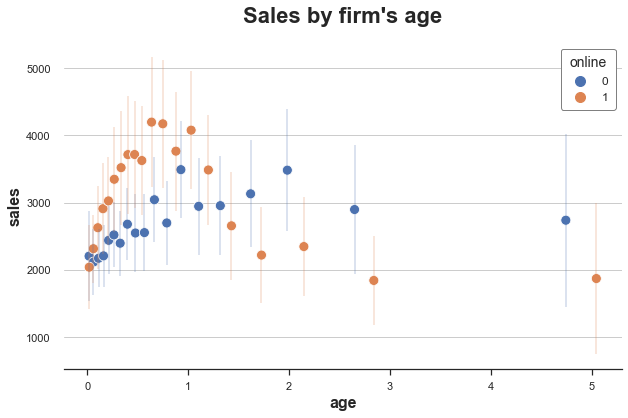

In [16]:
# Estimate binsreg
df_est = binscatter(x='age', y='sales', by='online', w=['products'], data=df, ci=(3,3))

# Plot binned scatterplot
sns.scatterplot(x='age', y='sales', data=df_est, hue='online');
plt.errorbar('age', 'sales', yerr='ci', data=df_est.query("online==0"), ls='', lw=2, alpha=0.2);
plt.errorbar('age', 'sales', yerr='ci', data=df_est.query("online==1"), ls='', lw=2, alpha=0.2);
plt.title("Sales by firm's age");

From the binned scatterplot, we can see that `online` products have on average shorter lifetimes, with a higher initial peak in `sales`, followed by a sharper decline.